# 2020 US General Election

---

---

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

from statsmodels.stats.weightstats import DescrStatsW

import us

import sys

import os
path = os.getcwd()
path = path[:path.find('us_election2020')] + 'us_election2020'

sys.path.append(path + '\\src\\data')
import make_dataset

In [2]:
make_dataset.general_election_polls2020_preprocessig()

In [3]:
make_dataset.president_approval_polls2020_preprocessig()

In [4]:
polls2020 = pd.read_csv(path + '\data\processed\general_election_polls2020.csv', 
                        parse_dates=['start_date', 'end_date', 'created_at'], index_col=['start_date'])

In [5]:
polls2020

,poll_id,question_id,state,pollster_id,pollster,sample_size,population,end_date,created_at,url,Trump,Biden,diff,population_weight,weight
start_date,,,,,,,,,,,,,,,
2018-11-27,57026,92080,Ohio,383,Public Policy Polling,648.0,v,2018-11-28,2018-12-06 14:43:00,https://www.cleveland.com/politics/2018/11/thi...,44.00,48.00,4.0,0.8,518.4
2018-12-16,57170,92351,National,1416,Harris Insights & Analytics,1001.0,rv,2018-12-17,2018-12-25 23:57:00,https://thehill.com/hilltv/what-americas-think...,36.00,42.00,6.0,0.9,900.9
2019-01-04,57275,92597,North Carolina,383,Public Policy Polling,750.0,rv,2019-01-07,2019-01-09 13:09:00,https://www.publicpolicypolling.com/wp-content...,44.00,49.00,5.0,0.9,675.0
2019-01-19,57365,92773,National,383,Public Policy Polling,760.0,rv,2019-01-21,2019-01-22 13:58:00,https://www.publicpolicypolling.com/wp-content...,41.00,53.00,12.0,0.9,684.0
2019-01-24,57427,92926,Michigan,176,Glengariff Group,600.0,lv,2019-01-26,2019-01-29 21:17:00,https://www.clickondetroit.com/michigan-politi...,40.30,53.30,13.0,1.0,600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-01,68475,128193,National,1515,Data for Progress,695.0,rv,2020-09-01,2020-09-04 09:05:00,https://docs.google.com/spreadsheets/d/1dGGzVg...,42.82,53.02,10.2,0.9,625.5
2020-09-01,68474,128191,Florida,1250,Trafalgar Group,1022.0,lv,2020-09-03,2020-09-04 09:01:00,https://drive.google.com/file/d/1sO8P6BXoAAgz-...,48.70,45.60,-3.1,1.0,1022.0
2020-09-02,68494,128230,National,568,YouGov,2433.0,lv,2020-09-04,2020-09-06 10:32:00,https://drive.google.com/file/d/1hmvwY-EJIMWKv...,42.00,52.00,10.0,1.0,2433.0


---

---

---

In [6]:
def get_state_statsSmooth_atK(df, candidates, state, k):
    """
    Get candidate's average and standard deviation (weighted) in state
    INPUT:
    - df: dataframe with polls statistics
    - candidates: list of candidates to return stats
    - state: US state
    - k: last k polls to analyse
    
    OUTPUT:
    - df with candidates avg, diff avd, and std
    """
    
    candidates = candidates + ['diff']
    cols_avg = [c + '_avg' for c in candidates]
    cols_std = [c + '_std' for c in candidates]
    cols_wgt = ['weight_'+ c for c in candidates]

    df = df[df['state'] == state]
    df = df[candidates + ['pollster_id', 'weight']]

    start = str(df.index.min().date())
    end = str(datetime.today().date())

    index_stats_df = pd.date_range(start=start, end=end, freq='D')
    cols_stats_df = cols_avg + cols_std
    
    state_stats_df = pd.DataFrame(index=index_stats_df, columns=cols_stats_df)
    
    df['weight'] = (df[['weight']])**(1/4)
    
    day0 = index_stats_df[0]
    atK_df = df.loc[:day0].tail(k)
    atK_pollsTimes = atK_df.groupby('pollster_id').count()[['weight']].rename(columns={'weight':'times'}).reset_index()
    atK_df = atK_df.merge(atK_pollsTimes, on='pollster_id')
    atK_df['weight'] = atK_df['weight']/(atK_df['times'])
    
    state_stats_df.loc[day0, cols_avg] = atK_df[candidates].values[0]
    state_stats_df.loc[day0, cols_std] = np.nan
    
    for day in index_stats_df[1:]:
        atK_df = df.loc[:day].tail(k)
        
        atK_pollsTimes = atK_df.groupby('pollster_id').count()[['weight']].rename(columns={'weight':'times'}).reset_index()
        atK_df = atK_df.merge(atK_pollsTimes, on='pollster_id')
        atK_df['weight'] = atK_df['weight']/(atK_df['times'])
            
        for col in cols_wgt:
            atK_df[col] = atK_df['weight']
            
        r_dispersion = ((np.abs((atK_df[candidates] - state_stats_df[cols_avg].dropna().iloc[-1].values)) + 1).values**(2))
        atK_df[cols_wgt] /= r_dispersion
        
        atK_df['weight'] = np.min(atK_df[cols_wgt], axis='columns')**(1/2)
    
        for i in range(3):
            weighted_stats = DescrStatsW(atK_df[candidates[i]], weights=atK_df['weight'], ddof=0)
            state_stats_df.loc[day, [cols_avg[i]]] = weighted_stats.mean.reshape(-1,)
            state_stats_df.loc[day, [cols_std[i]]] = weighted_stats.std.reshape(-1,)

    state_stats_df = state_stats_df.dropna(axis='rows', how='all').astype(float)
    
    if candidates == (['Biden', 'Trump'] + ['diff']) and state == 'National':
        round(state_stats_df, 4).to_csv(path+'\\data\\processed\\2020_National_stats_at'+str(k)+'.csv')
    
    if state == 'National' and candidates == (['approve', 'disapprove'] + ['diff']):
        round(state_stats_df, 4).to_csv(path+'\\data\\processed\\2020_TrumpApproval_stats_at'+str(k)+'.csv')
    return round(state_stats_df, 4)

In [7]:
def get_Allstates_statsSmooth_atK(df, candidates=['Biden', 'Trump'], k=16):
    
    df = df.loc['2020-01-01':]
    
    Allstate_stats_df = pd.DataFrame()
    for state in sorted(df['state'].unique()):
        print(state, end='                    \r')
        state_stats_df = get_state_statsSmooth_atK(df, candidates, state, k)
        state_stats_df['state'] = state
        Allstate_stats_df = Allstate_stats_df.append(state_stats_df)
        
    round(Allstate_stats_df, 4).to_csv(path+'\\data\\processed\\2020_AllStates_stats_k'+str(k)+'.csv')
    return round(Allstate_stats_df, 4)

In [8]:
national_statsSmooth_k = get_state_statsSmooth_atK(polls2020, candidates=['Biden', 'Trump'], state='National', k=8)
national_statsSmooth_2k = get_state_statsSmooth_atK(polls2020, candidates=['Biden', 'Trump'], state='National', k=16)

In [9]:
def get_table_atK(df, state, k, election=2020):
    """
    Get table with last k polls in the state with sample size and type of respondents (population)
    INPUT:
    - df: dataframe with polls statistics
    - candidates: list of candidates to return stats
    - state: US state
    - k: last k polls to analyse
    
    OUTPUT:
    - df with candidates avg, diff avd, and std
    """
    
    df = df[df['state'] == state]
    df = df.reset_index()
    df = df.reset_index().set_index(['start_date', 'end_date', 'pollster', 'population', 'sample_size'])
    if election == 2020:
        candidates = ['Biden', 'Trump']
    elif election == 2016:
        candidates = ['Clinton', 'Trump']
    df = df[candidates].tail(k).sort_index(level=['start_date', 'end_date'], ascending=[False, False])
    
    return df

In [10]:
def get_polls_plot_atK(df, state, k, election=2020):
    """
    Plot graphs
    INPUT:
    - df: dataframe with polls statistics
    - state: US state
    - k: last k polls to analyse
    - election: 2016, 2020, or pr_approval
    
    OUTPUT:
    - plot
    """
    if election == 'pr_approval':
        candidates = ['approve', 'disapprove']
        candidates_color = {'approve':'darkorange', 'disapprove':'darkgreen'}
    if election == 2020:
        candidates = ['Biden', 'Trump']
        candidates_color = {'Biden':'blue', 'Trump':'red'}
    elif election == 2016:
        candidates = ['Clinton', 'Trump']
        candidates_color = {'Clinton':'blue', 'Trump':'red'}
    
    state_polls2020 = df[df['state'] == state]
    if state == 'National' and election == 2020:
        state_stats_k = pd.read_csv(path+'\\data\\processed\\2020_National_stats_at'+str(k)+'.csv', parse_dates=True, index_col=0)
        state_stats_kHalf = pd.read_csv(path+'\\data\\processed\\2020_National_stats_at'+str(int(k/2))+'.csv', parse_dates=True, index_col=0)
    elif state == 'National' and  election == 'pr_approval':
        state_stats_k = pd.read_csv(path+'\\data\\processed\\2020_TrumpApproval_stats_at'+str(24)+'.csv', parse_dates=True, index_col=0)
        state_stats_kHalf = pd.read_csv(path+'\\data\\processed\\2020_TrumpApproval_stats_at'+str(int(16))+'.csv', parse_dates=True, index_col=0)
    else:
        state_stats_k = pd.read_csv(path+'\\data\\processed\\2020_AllStates_stats_k'+str(k)+'.csv', parse_dates=True, index_col=0)
        state_stats_k = state_stats_k.loc[state_stats_k['state']==state]
        state_stats_kHalf = pd.read_csv(path+'\\data\\processed\\2020_AllStates_stats_k'+str(int(k/2))+'.csv', parse_dates=True, index_col=0)
        state_stats_kHalf = state_stats_kHalf.loc[state_stats_kHalf['state']==state]

    plt.figure(figsize=(15, 7.5))
    
    for candidate in candidates:
        plt.scatter(state_polls2020.index, state_polls2020[candidate], color=candidates_color[candidate], s=2.5)
        plt.plot(state_stats_k[candidate+'_avg'], color=candidates_color[candidate], lw=1.5, label=candidate+' - k='+str(k))
        plt.plot(state_stats_kHalf[candidate+'_avg'], color=candidates_color[candidate], lw=1, alpha=0.75, ls='--', label=candidate+' - k='+str(int(k/2)))
        
        plt.text(x=state_stats_k[candidate+'_avg'].index[-1] + timedelta(days=2.5),
                 y=state_stats_k[candidate+'_avg'].iloc[-1], fontsize=12.5,
                 s=str(round(state_stats_k[candidate+'_avg'].iloc[-1], 1)), color=candidates_color[candidate])


        plt.fill_between(state_stats_k[candidate+'_avg'].index,
                         state_stats_k[candidate+'_avg']+2*state_stats_k[candidate+'_std'],
                         state_stats_k[candidate+'_avg']-2*state_stats_k[candidate+'_std'],
                         alpha=0.1, color=candidates_color[candidate])
        plt.fill_between(state_stats_k[candidate+'_avg'].index,
                         state_stats_k[candidate+'_avg']+state_stats_k[candidate+'_std'],
                         state_stats_k[candidate+'_avg']-state_stats_k[candidate+'_std'],
                         alpha=0.2, color=candidates_color[candidate])

    plt.legend()
    if election == 'pr_approval': 
        plt.xlim(xmin=datetime(2019, 1, 1), xmax=state_stats_k.index.max() + timedelta(days=21))
        plt.ylim((30, 65))
        plt.title('2020 US General Election - Trump Job Approval', fontsize=15)
        plt.grid(ls='--', alpha=0.5)
        plt.tight_layout()
        plt.savefig(path+'\\reports\\figures\\2020_US_Genereal_Election-TrumpJobApproval.png')
    else: 
        plt.xlim(xmin=datetime(2020, 1, 1), xmax=state_stats_k.index.max() + timedelta(days=21))
        plt.ylim((35, 55))
        plt.title('2020 US General Election - '+state, fontsize=15)
        plt.grid(ls='--', alpha=0.5)
        plt.tight_layout()
        plt.savefig(path+'\\reports\\figures\\2020_US_Genereal_Election-'+state+'-polls.png')

    plt.show()

---

---

---

# National Report

## 1. who leads the National preference to be the US next president?

---

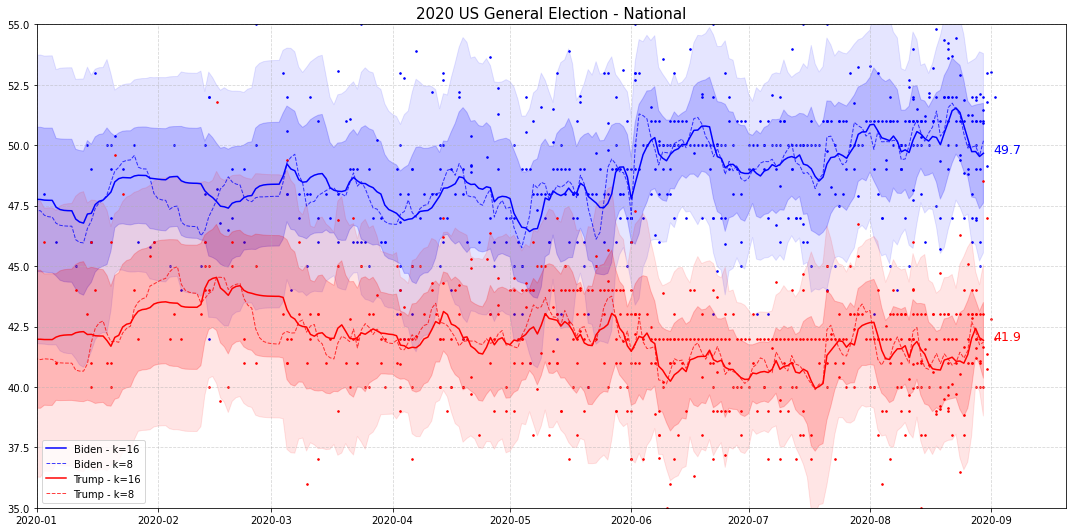

Biden  \
start_date end_date   pollster                       population sample_size          
2020-09-02 2020-09-04 YouGov                         lv         2433.0       52.00   
2020-09-01 2020-09-01 Data for Progress              rv         695.0        53.02   
2020-08-31 2020-09-06 USC Dornsife/Los Angeles Times lv         2588.0       51.81   
           2020-09-02 Harris Insights & Analytics    lv         NaN          53.00   
           2020-09-01 Redfield & Wilton Strategies   lv         1835.0       49.14   
2020-08-30 2020-09-05 USC Dornsife/Los Angeles Times lv         2575.0       50.94   
           2020-09-01 YouGov                         rv         1209.0       51.00   
           2020-08-31 Emerson College                lv         1567.0       51.46   
           2020-08-30 Morning Consult                lv         4000.0       52.00   
2020-08-29 2020-09-04 USC Dornsife/Los Angeles Times lv         2563.0       52.11   

                                                                             Trump  
start_date end_date   pollster                       population sample_size         
2020-09-02 2020-09-04 YouGov                         lv         2433.0       42.00  
2020-09-01 2020-09-01 Data for Progress              rv         695.0        42.82  
2020-08-31 2020-09-06 USC Dornsife/Los Angeles Times lv         2588.0       41.35  
           2020-09-02 Harris Insights & Analytics    lv         NaN          47.00  
           2020-09-01 Redfield & Wilton Strategies   lv         1835.0       40.75  
2020-08-30 2020-09-05 USC Dornsife/Los Angeles Times lv         2575.0       41.67  
           2020-09-01 YouGov                         rv         1209.0       40.00  
           2020-08-31 Emerson College                lv         1567.0       48.54  
           2020-08-30 Morning Consult                lv         4000.0       43.00  
2020-08-29 2020-09-04 USC Dornsife/Los Angeles Times lv         2563.0       41.08

In [11]:
get_polls_plot_atK(polls2020, 'National', 16, election=2020)
get_table_atK(polls2020, 'National', k=10)

In [12]:
def get_states_diff_distribution(df, k, election=2020, on_day=str(datetime.today().date())):
    """
    Get difference distribution between candidates (Democrat - Republican) per state
    INPUT:
    - df: dataframe with polls statistics
    - state: US state
    - k: last k polls to analyse
    - on_day: difference between candidates on day
    
    OUTPUT:
    - df with last_poll avg date, candidate avg, and difference between candidates
    """
    
    pass

In [13]:
get_states_diff_distribution(polls2020, k=20, election=2020, on_day=str(datetime.today().date()))

In [14]:
def get_election_results():
    """
    Get difference distribution between candidates (Democrat - Republica) per state
    INPUT:
    - 
    
    OUTPUT:
    - df with results of 2016 US General Election
    """
    
    us_election_results = pd.read_csv(path+'\\data\\external\\us_election_results.csv', 
                                      header=[0,1], index_col=0)
    
    us_election_results[('2016', 'diff')] = us_election_results['2016']['Clinton'] - us_election_results['2016']['Trump']
    us_election_results[('2012', 'diff')] = us_election_results['2012']['Obama'] - us_election_results['2012']['Romney']
    us_election_results[('2008', 'diff')] = us_election_results['2012']['Obama'] - us_election_results['2008']['Mccain']
    
    us_election_results.columns = [(col[1]+'_'+col[0]) for col in us_election_results.columns]
    return us_election_results

def get_electoral_college():
    """
    Get electoral college per state
    INPUT:
    - 
    
    OUTPUT:
    - df with electoral college per US state
    """
    
    us_college = pd.read_csv(path+'\\data\\external\\us_college.csv', index_col='state')
    return us_college

In [44]:
def get_expected_electoral_college(k=16, election=2020, on_day=str(datetime.today().date())):
    """
    Get full df with last poll data avg, candidates avg, 2008-2016 General Election Results and 
    cumulate electoral college for Democrat and Republican candidates
    INPUT:
    - df: dataframe with polls statistics
    - k: last k polls to analyse
    - on_day: difference between candidates on day
    
    OUTPUT:
    - df
    """
    
    us_election_results = get_election_results()[['Clinton_2016', 'Trump_2016', 'diff_2016']]
    us_college = get_electoral_college()
    
    filename = '2020_AllStates_stats_k'+str(k)+'.csv'
    Allstates_stats_atK = pd.read_csv(path+'\\data\\processed\\'+filename, parse_dates=True, index_col=0)
    
    #Allstates_stats_atK = Allstates_stats_atK.sort_index().drop_duplicates(subset=['state'], keep='last').sort_values('diff_avg')
    Allstates_stats_atK = Allstates_stats_atK.loc[on_day]

    Allstates_stats_atK = Allstates_stats_atK.merge(us_college, how='right', left_on='state', right_on=us_college.index)
    Allstates_stats_atK = Allstates_stats_atK.merge(us_election_results, how='outer', left_on='state', right_on=us_election_results.index)

    Allstates_stats_atK.loc[Allstates_stats_atK['diff_avg'].isna(), ['diff_avg']] = Allstates_stats_atK.loc[Allstates_stats_atK['diff_avg'].isna(), ['diff_2016']].values
    Allstates_stats_atK['lean'] = Allstates_stats_atK['diff_avg'].apply(lambda x: 'Biden' if x>0 else ('Trump' if x<0 else 'tie'))
    Allstates_stats_atK = Allstates_stats_atK.sort_values('diff_avg')
    Allstates_stats_atK['abs.diff_avg'] = np.abs(Allstates_stats_atK['diff_avg'])

    Allstates_stats_atK['expected_college_cumsum'] = 0
    Allstates_stats_atK.loc[Allstates_stats_atK['lean'] == 'Trump', ['expected_college_cumsum']] = Allstates_stats_atK.loc[Allstates_stats_atK['lean'] == 'Trump', ['electoral_college']].cumsum().values
    Allstates_stats_atK.loc[Allstates_stats_atK['lean'] == 'Biden', ['expected_college_cumsum']] = Allstates_stats_atK.loc[Allstates_stats_atK['lean'] == 'Biden', ['electoral_college']][::-1].cumsum()[::-1].values

    Allstates_stats_atK['index'] = Allstates_stats_atK['state']+' ('+Allstates_stats_atK['electoral_college'].astype(str)+')'
    Allstates_stats_atK = Allstates_stats_atK.set_index(['index'])

    Allstates_stats_atK.to_csv(path+'\\data\\processed\\2020_Allstates_ElectoralCollege_k'+str(k)+'.csv')
    return Allstates_stats_atK

In [16]:
k = 16
national_stats_k16 = pd.read_csv(path+'\\data\\processed\\2020_National_stats_at'+str(k)+'.csv', parse_dates=True, index_col=0)

In [17]:
national_stats_2k_2016 = pd.read_csv(path+'\\data\\processed\\2016_National_stats_at16.csv', parse_dates=True, index_col=0)
national_stats_k_2016 = pd.read_csv(path+'\\data\\processed\\2016_National_stats_at8.csv', parse_dates=True, index_col=0)

national_stats_2k_2016.index = pd.date_range(end='2020-11-03', freq='D', periods=len(national_stats_2k_2016.index))

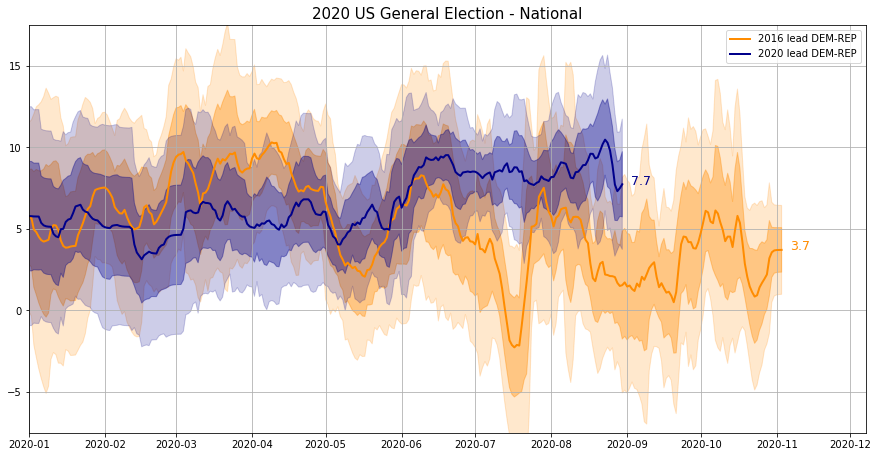

In [18]:
plt.figure(figsize=(15, 7.5))


plt.plot(national_stats_2k_2016['diff_avg'], lw=2., label='2016 lead DEM-REP', color='darkorange')

plt.plot(national_stats_k16['diff_avg'], lw=2., label='2020 lead DEM-REP', color='darkblue')

for candidate in ['Clinton', 'Trump']:
    plt.fill_between(national_stats_2k_2016['diff_avg'].index,
                     national_stats_2k_2016['diff_avg']+2*national_stats_2k_2016['diff_std'],
                     national_stats_2k_2016['diff_avg']-2*national_stats_2k_2016['diff_std'],
                     alpha=0.1, color='darkorange')
    plt.fill_between(national_stats_2k_2016['diff_avg'].index,
                     national_stats_2k_2016['diff_avg']+national_stats_2k_2016['diff_std'],
                     national_stats_2k_2016['diff_avg']-national_stats_2k_2016['diff_std'],
                     alpha=0.2, color='darkorange')

for candidate in ['Biden', 'Trump']:
    plt.fill_between(national_stats_k16['diff_avg'].index,
                     national_stats_k16['diff_avg']+2*national_stats_k16['diff_std'],
                     national_stats_k16['diff_avg']-2*national_stats_k16['diff_std'],
                     alpha=0.1, color='darkblue')
    plt.fill_between(national_stats_k16['diff_avg'].index,
                     national_stats_k16['diff_avg']+national_stats_k16['diff_std'],
                     national_stats_k16['diff_avg']-national_stats_k16['diff_std'],
                     alpha=0.2, color='darkblue')

plt.text(x=national_stats_2k_2016.index[-1] + timedelta(3.5), 
         y=round(national_stats_2k_2016['diff_avg'].iloc[-1], 1), 
         s=str(round(national_stats_2k_2016['diff_avg'].iloc[-1], 1)), 
         fontsize=12.5, color='darkorange')
plt.text(x=national_stats_k16.index[-1] + timedelta(3.5), 
         y=round(national_stats_k16['diff_avg'].iloc[-1], 1), 
         s=str(round(national_stats_k16['diff_avg'].iloc[-1], 1)), 
         fontsize=12.5, color='darkblue')
    

plt.ylim((-7.5, 17.5))
plt.title('2020 US General Election lead - National', fontsize=15)
plt.legend()
plt.grid()
plt.xlim(xmin=pd.to_datetime('2020-01-01'))
plt.show()

---

---

---

# States report
## 2. how US states are leaned to vote?
---

In [19]:
Allstates_stats_k16 = get_Allstates_statsSmooth_atK(polls2020, candidates=['Biden', 'Trump'], k=8)
print('\n---')
Allstates_stats_k16 = get_Allstates_statsSmooth_atK(polls2020, candidates=['Biden', 'Trump'], k=16)
print('\n---')

Wisconsin                         
---
Wisconsin                         
---


In [45]:
Allstates_diff_k16 = get_expected_electoral_college(k=16, election=2020, on_day=str(datetime.today().date()))

In [46]:
Allstates_diff_k16

,Biden_avg,Trump_avg,diff_avg,Biden_std,Trump_std,diff_std,state,electoral_college,Clinton_2016,Trump_2016,diff_2016,lean,abs.diff_avg,expected_college_cumsum
index,,,,,,,,,,,,,,
Wyoming (3),NaN,NaN,-46.2900,NaN,NaN,NaN,Wyoming,3,21.88,68.17,-46.29,Trump,46.2900,3
West Virginia (5),31.0000,66.0000,-35.0000,0.0000,0.0000,0.0000,West Virginia,5,26.43,68.50,-42.07,Trump,35.0000,8
Idaho (4),NaN,NaN,-31.7700,NaN,NaN,NaN,Idaho,4,27.49,59.26,-31.77,Trump,31.7700,12
South Dakota (3),NaN,NaN,-29.7900,NaN,NaN,NaN,South Dakota,3,31.74,61.53,-29.79,Trump,29.7900,15
Oklahoma (7),34.7801,57.1307,-22.3506,1.3527,2.3133,3.2061,Oklahoma,7,28.93,65.32,-36.39,Trump,22.3506,22
Alabama (9),38.0058,57.4619,-19.4562,1.2092,1.7952,2.6797,Alabama,9,34.36,62.08,-27.72,Trump,19.4562,31
North Dakota (3),38.0000,55.9975,-17.9975,0.0000,1.0000,1.0000,North Dakota,3,27.23,62.96,-35.73,Trump,17.9975,34
Kentucky (8),37.5850,54.9208,-17.3357,2.7793,2.5092,4.7131,Kentucky,8,32.68,62.52,-29.84,Trump,17.3357,42
Utah (6),33.4272,49.4111,-15.9839,3.0651,1.3115,4.1997,Utah,6,27.46,45.54,-18.08,Trump,15.9839,48


In [21]:
states_statsSmoothk16_2016 = pd.read_csv(path+'\\data\\processed\\2016_States_stats_at16.csv', parse_dates=True, index_col=0)
states_statsSmoothk16_atElectionDay2016 = states_statsSmoothk16_2016.loc['2016-11-08']
states_statsSmoothk16_atEqDay2016 = states_statsSmoothk16_2016.loc['2016'+str(datetime.today().date()+timedelta(days=5))[4:]]

In [22]:
states_statsSmoothk16_atElectionDay2016 = states_statsSmoothk16_atElectionDay2016.merge(Allstates_diff_k16['state'].reset_index()).set_index('index')
states_statsSmoothk16_atEqDay2016 = states_statsSmoothk16_atEqDay2016.merge(Allstates_diff_k16['state'].reset_index()).set_index('index')

In [23]:
period = pd.date_range(start='2020-01-15', end=str(datetime.today().date()), freq='D')
college_evolution = pd.DataFrame(index=period, columns=['Biden', 'Biden_over4pts', 'Trump', 'Trump_over4pts'])

for day in period:
    day = day.date()
    print('\r{}          '.format(day), end='', flush=True)
    
    candidates_college = get_expected_electoral_college(k=16, election=2020, on_day=day)
    
    biden_college = candidates_college.loc[candidates_college['lean']=='Biden', 'expected_college_cumsum'].max()
    trump_college = candidates_college.loc[candidates_college['lean']=='Trump', 'expected_college_cumsum'].max()
    biden_over4pts_college = candidates_college.loc[(candidates_college['abs.diff_avg']>4)&(candidates_college['lean']=='Biden'), 'expected_college_cumsum'].max()
    trump_over4pts_college = candidates_college.loc[(candidates_college['abs.diff_avg']>4)&(candidates_college['lean']=='Trump'), 'expected_college_cumsum'].max()
    
    college_evolution.loc[day, ['Biden', 'Biden_over4pts', 'Trump', 'Trump_over4pts']] = biden_college, biden_over4pts_college, trump_college, trump_over4pts_college
    
college_evolution.to_csv(path+'\\data\\processed\\2020_ElectoralCollege_evolution_k16.csv')

2020-09-07          

In [24]:
college_evolution = pd.read_csv(path+'\\data\\processed\\2020_ElectoralCollege_evolution_k16.csv', parse_dates=True, index_col=0)

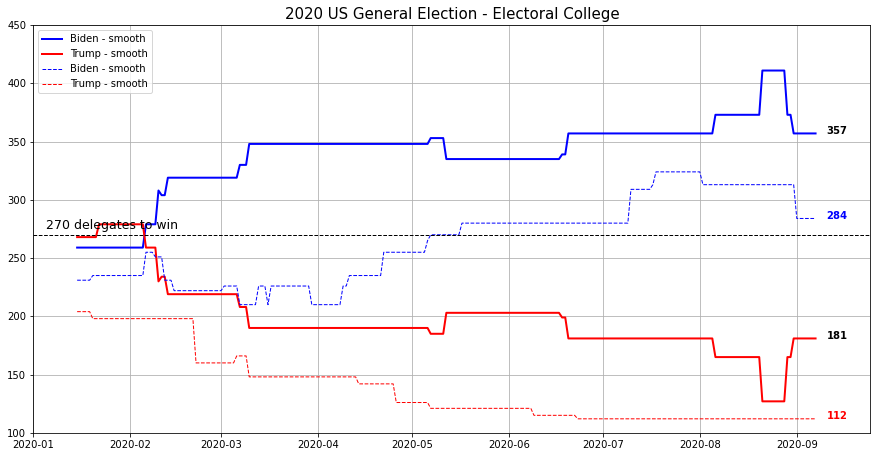

In [25]:
plt.figure(figsize=(15, 7.5))

plt.plot(college_evolution[['Biden']], lw=2., label='Biden - smooth', color='blue')
plt.plot(college_evolution[['Trump']], lw=2., label='Trump - smooth', color='red')
plt.plot(college_evolution[['Biden_over4pts']], lw=1., ls='--', label='Biden - smooth', color='blue')
plt.plot(college_evolution[['Trump_over4pts']], lw=1., ls='--', label='Trump - smooth', color='red')


plt.text(x=college_evolution['Biden'].iloc[[-1]].index[0] + timedelta(days=3.5), 
         y=college_evolution['Biden'].iloc[-1], 
         s=str(college_evolution['Biden'].iloc[-1]), color='black', fontweight='bold')
plt.text(x=college_evolution['Trump'].iloc[[-1]].index[0] + timedelta(days=3.5), 
         y=college_evolution['Trump'].iloc[-1], 
         s=str(college_evolution['Trump'].iloc[-1]), color='black', fontweight='bold')

plt.text(x=college_evolution['Biden_over4pts'].iloc[[-1]].index[0] + timedelta(days=3.5), 
         y=college_evolution['Biden_over4pts'].iloc[-1], 
         s=str(college_evolution['Biden_over4pts'].iloc[-1]), color='blue', fontweight='bold')
plt.text(x=college_evolution['Trump_over4pts'].iloc[[-1]].index[0] + timedelta(days=3.5), 
         y=college_evolution['Trump_over4pts'].iloc[-1], 
         s=str(college_evolution['Trump_over4pts'].iloc[-1]), color='red', fontweight='bold')


plt.title('2020 US General Election - Electoral College', fontsize=15)
plt.legend()
plt.grid()

plt.xlim(xmin=pd.to_datetime('2020-01-01'), xmax=college_evolution.iloc[[-1]].index[0] +timedelta(days=3.5)+timedelta(days=14))
plt.ylim(100, 450)

plt.axhline(y=270, color='black', ls='--', lw=1.)
plt.text(x=pd.to_datetime('2020-01-05'), y=275, s='270 delegates to win', fontsize=12.5)

plt.show()

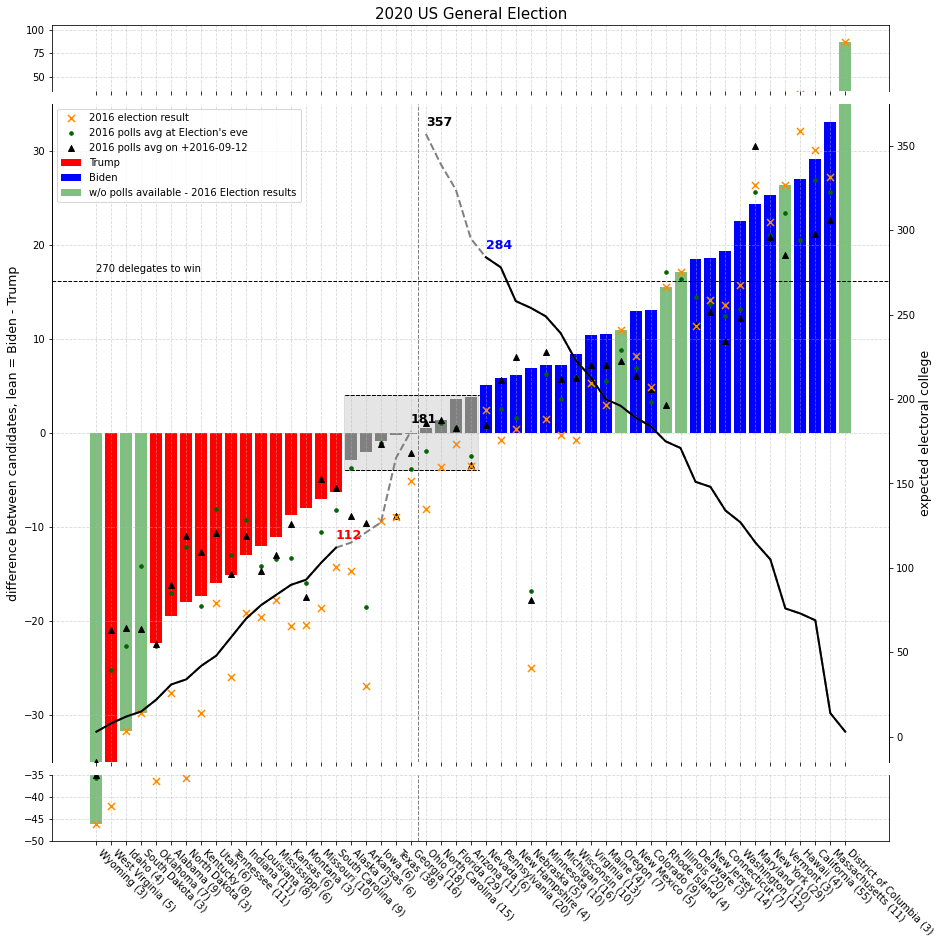

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15), sharex=True, 
                               gridspec_kw={'height_ratios': [0.5, 5, 0.5],  'hspace':0.05})
ax4 = ax2.twinx()


for a in [ax1, ax2, ax3]:
    
    a.scatter(x=2029.index, y=Allstates_diff_k16['diff_2016'], 
            color='darkorange', s=50., marker='x', zorder=5, label='2016 election result')
    a.scatter(x=states_statsSmoothk16_atElectionDay2016.index, y=states_statsSmoothk16_atElectionDay2016['diff_avg'], 
            color='darkgreen', s=50., marker='.', zorder=4, label='2016 polls avg at Election\'s eve')
    a.scatter(x=states_statsSmoothk16_atEqDay2016.index, y=states_statsSmoothk16_atEqDay2016['diff_avg'], 
            color='black', s=35., marker='^', zorder=4, label='2016 polls avg on +''2016'+str(datetime.today().date()+timedelta(days=5))[4:])
    
    a.bar(x=Allstates_diff_k16.loc[Allstates_diff_k16['lean'] == 'Trump', ['diff_avg']].index,
            height=Allstates_diff_k16.loc[Allstates_diff_k16['lean'] == 'Trump', ['diff_avg']].values.T[0], 
            color='red', label='Trump')
    a.bar(x=Allstates_diff_k16.loc[Allstates_diff_k16['lean'] == 'Biden', ['diff_avg']].index,
            height=Allstates_diff_k16.loc[Allstates_diff_k16['lean'] == 'Biden', ['diff_avg']].values.T[0], 
            color='blue', label='Biden')
    a.bar(x=Allstates_diff_k16.loc[Allstates_diff_k16['Biden_avg'].isna(), ['diff_avg']].index,
            height=Allstates_diff_k16.loc[Allstates_diff_k16['Biden_avg'].isna(), ['diff_avg']].values.T[0], 
            color='white')
    a.bar(x=Allstates_diff_k16.loc[Allstates_diff_k16['Biden_avg'].isna(), ['diff_avg']].index,
            height=Allstates_diff_k16.loc[Allstates_diff_k16['Biden_avg'].isna(), ['diff_avg']].values.T[0], 
            color='green', alpha=0.5, label='w/o polls available - 2016 Election results')

    a.bar(x=Allstates_diff_k16.loc[(Allstates_diff_k16['abs.diff_avg']<4), ['diff_avg']].index,
            height=Allstates_diff_k16.loc[(Allstates_diff_k16['abs.diff_avg']<4), ['diff_avg']].values.T[0], 
            color='gray')   
    
    
ax4.plot(Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Trump'), ['expected_college_cumsum']], lw=2., ls='--', color='gray')
ax4.plot(Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Biden'), ['expected_college_cumsum']], lw=2., ls='--', color='gray')
ax4.plot(Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Trump')&(Allstates_diff_k16['diff_avg']<-4), ['expected_college_cumsum']], lw=2., color='black')
ax4.plot(Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Biden')&(Allstates_diff_k16['diff_avg']>4), ['expected_college_cumsum']], lw=2., color='black')

ax4.text(x=Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Biden')&(Allstates_diff_k16['diff_avg']>4), ['expected_college_cumsum']].iloc[[0]].index, 
         y=Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Biden')&(Allstates_diff_k16['diff_avg']>4), ['expected_college_cumsum']].iloc[[0]].values[0] + 5, 
         s=Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Biden')&(Allstates_diff_k16['diff_avg']>4), ['expected_college_cumsum']].iloc[0].values[0], 
         fontsize=12.5, fontweight='bold', color='blue')
ax4.text(x=Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Trump')&(Allstates_diff_k16['diff_avg']<-4), ['expected_college_cumsum']].iloc[[-1]].index, 
         y=Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Trump')&(Allstates_diff_k16['diff_avg']<-4), ['expected_college_cumsum']].iloc[[-1]].values[0] + 5, 
         s=Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Trump')&(Allstates_diff_k16['diff_avg']<-4), ['expected_college_cumsum']].iloc[-1].values[0], 
         fontsize=12.5, fontweight='bold', color='red')
ax4.text(x=Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Biden'), ['expected_college_cumsum']].iloc[[0]].index, 
         y=Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Biden'), ['expected_college_cumsum']].iloc[[0]].values[0] + 5, 
         s=Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Biden'), ['expected_college_cumsum']].iloc[0].values[0], 
         fontsize=12.5, fontweight='bold')
ax4.text(x=Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Trump'), ['expected_college_cumsum']].iloc[[-1]].index, 
         y=Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Trump'), ['expected_college_cumsum']].iloc[[-1]].values[0] + 5, 
         s=Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Trump'), ['expected_college_cumsum']].iloc[-1].values[0], 
         fontsize=12.5, fontweight='bold')


xmin = Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Trump')&(Allstates_diff_k16['abs.diff_avg']>4), ['expected_college_cumsum']].shape[0] - 0.5
xmax = 51 - Allstates_diff_k16.loc[(Allstates_diff_k16['lean'] == 'Biden')&(Allstates_diff_k16['abs.diff_avg']>4), ['expected_college_cumsum']].shape[0] - 0.5

ax2.fill_between(x=np.arange(xmin, xmax+0.5, step=0.5), y1=-4, y2=4, color='gray', alpha=0.2, zorder=0)
ax2.axhline(y=4, xmin=(xmin+1)/50, xmax=(xmax)/50, color='black', ls='--', lw=1.)
ax2.axhline(y=-4, xmin=(xmin+1)/50, xmax=(xmax)/50, color='black', ls='--', lw=1.)

ax4.axhline(y=270, color='black', ls='--', lw=1.)
ax4.text(x=0, y=275,
         s='270 delegates to win')

ax1.set_ylim(35,105)
ax2.set_ylim(-35,35)
ax3.set_ylim(-50,-35)

axvline_sep = Allstates_diff_k16.loc[Allstates_diff_k16['lean']=='Trump'].shape[0]+(Allstates_diff_k16.loc[Allstates_diff_k16['lean']=='tie'].shape[0]/2)-0.5
ax2.axvline(axvline_sep, color='gray', ls='--', lw=1.)
ax3.axvline(axvline_sep, color='gray', ls='--', lw=1.)
ax2.axhline(y=4, xmin=(xmin+1)/50, xmax=(xmax)/50, color='black', ls='--', lw=1.)
ax2.axhline(y=-4, xmin=(xmin+1)/50, xmax=(xmax)/50, color='black', ls='--', lw=1.)


ax1.grid(which='both', axis='both', ls='--', alpha=0.5)
ax2.grid(which='both', axis='both', ls='--', alpha=0.5)
ax3.grid(which='both', axis='both', ls='--', alpha=0.5)

# Hide the right and top spines
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax3.spines['top'].set_visible(False)

ax2.legend()
ax3.set_xticklabels(Allstates_diff_k16.index, rotation=-45, ha='left')
ax1.set_title('2020 US General Election', fontsize=15)
ax2.set_ylabel('difference between candidates, lean = Biden - Trump', fontsize=12.5)
ax4.set_ylabel('expected electoral college', fontsize=12.5)
plt.show()

### Swing States
#### EX: Texas and Florida
---

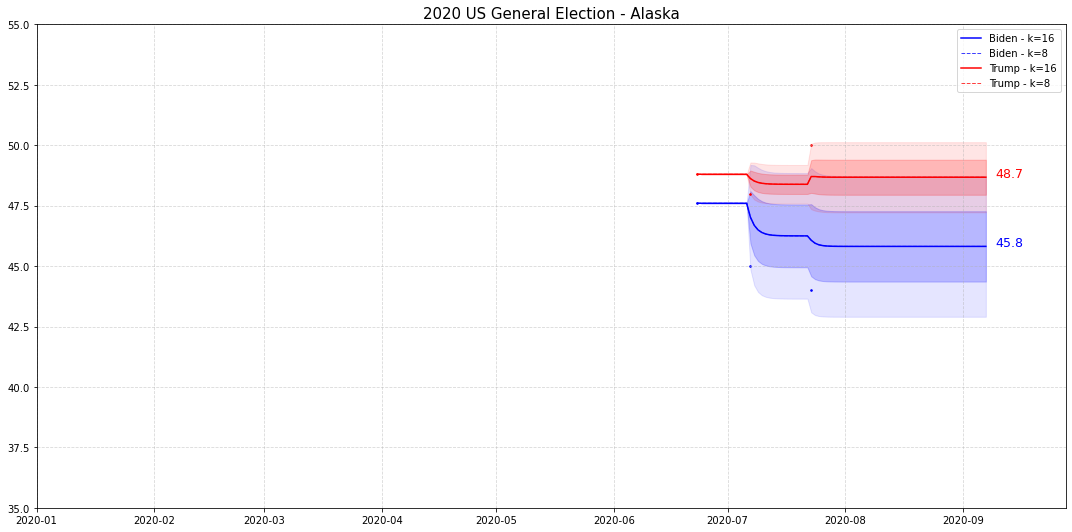

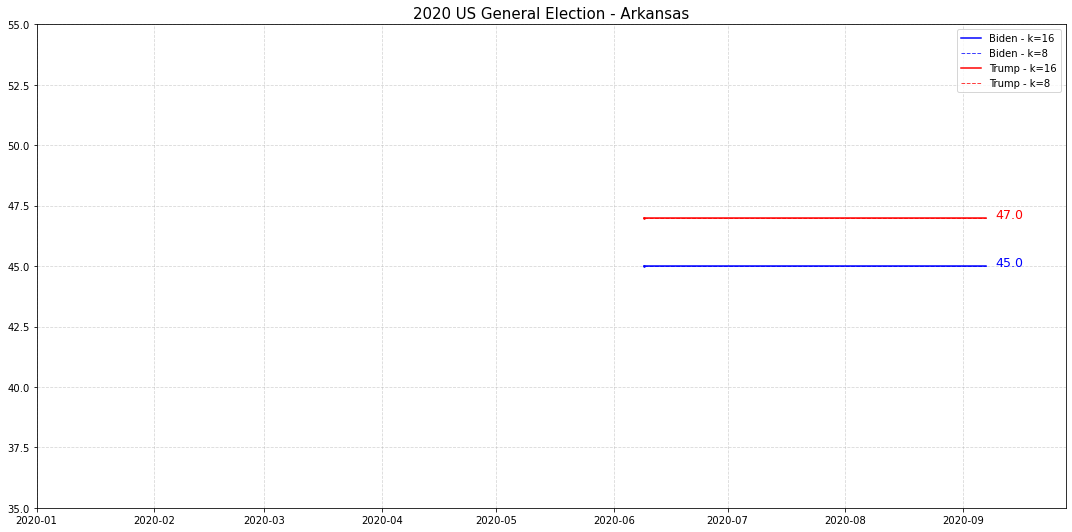

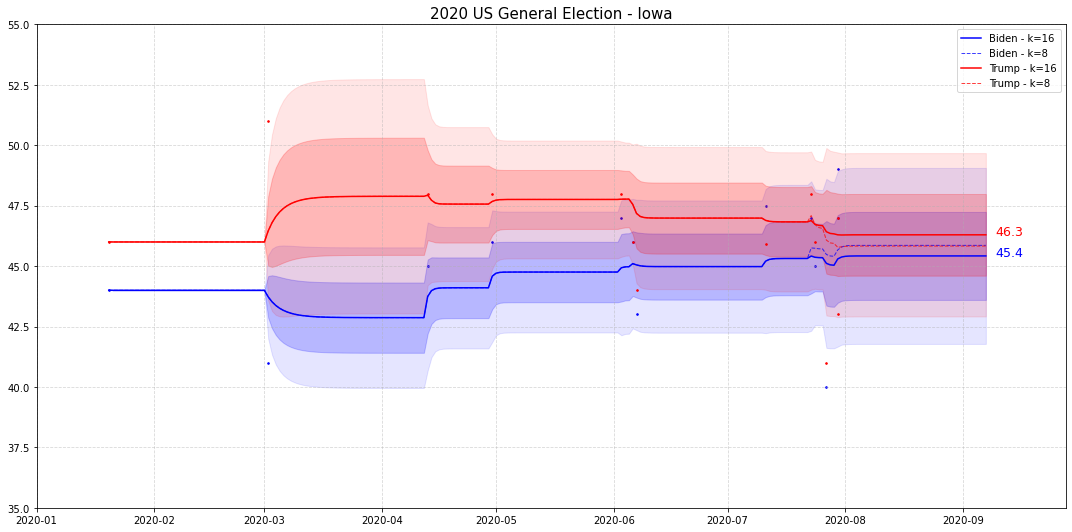

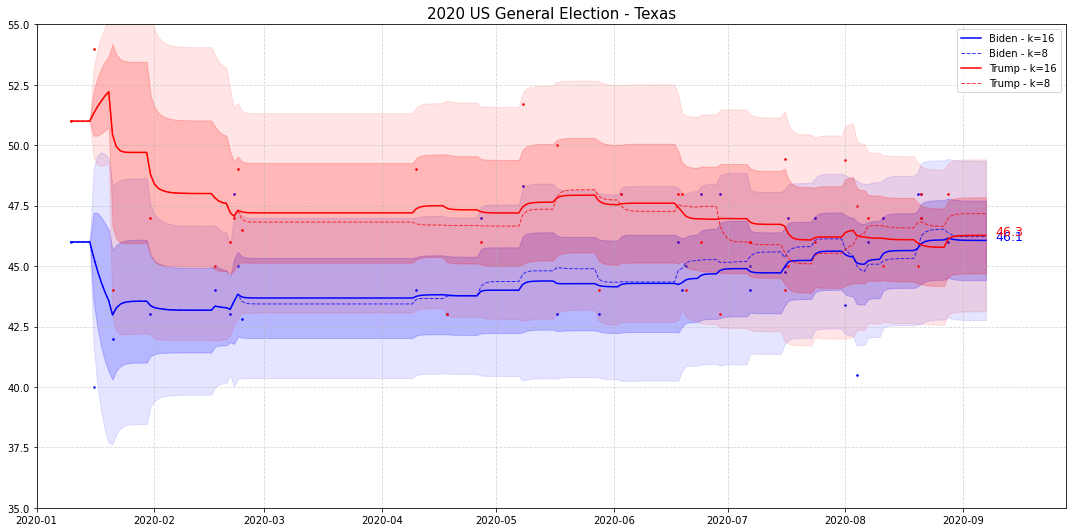

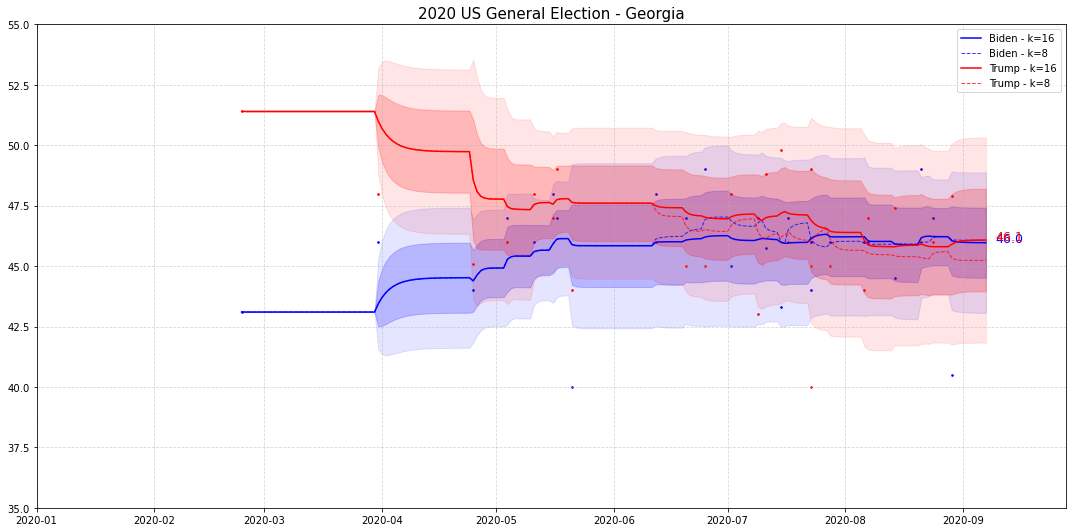

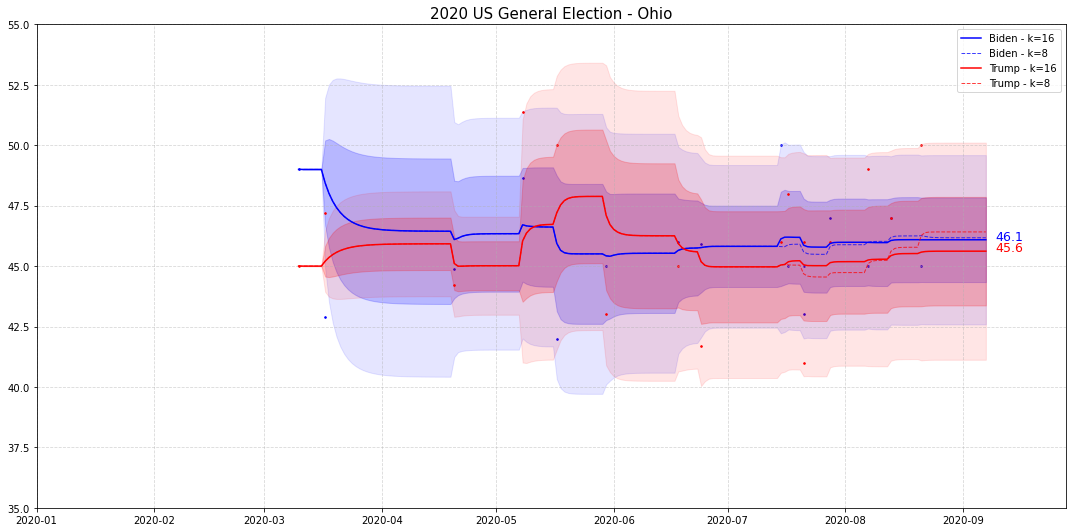

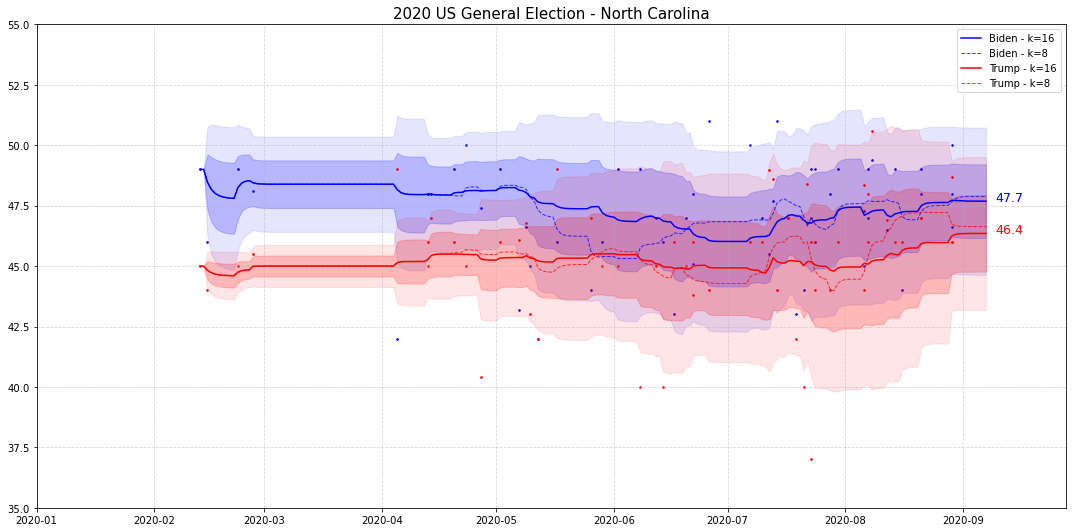

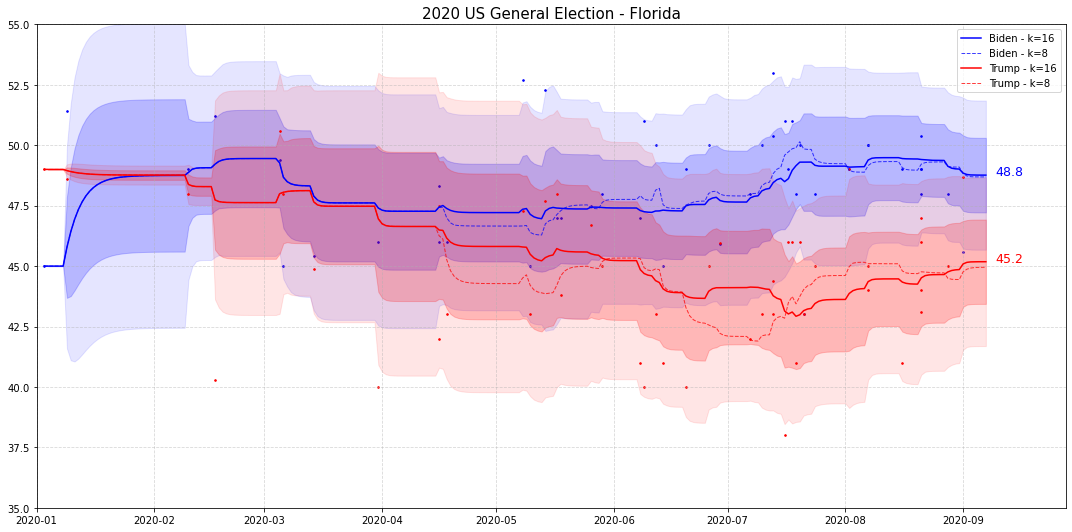

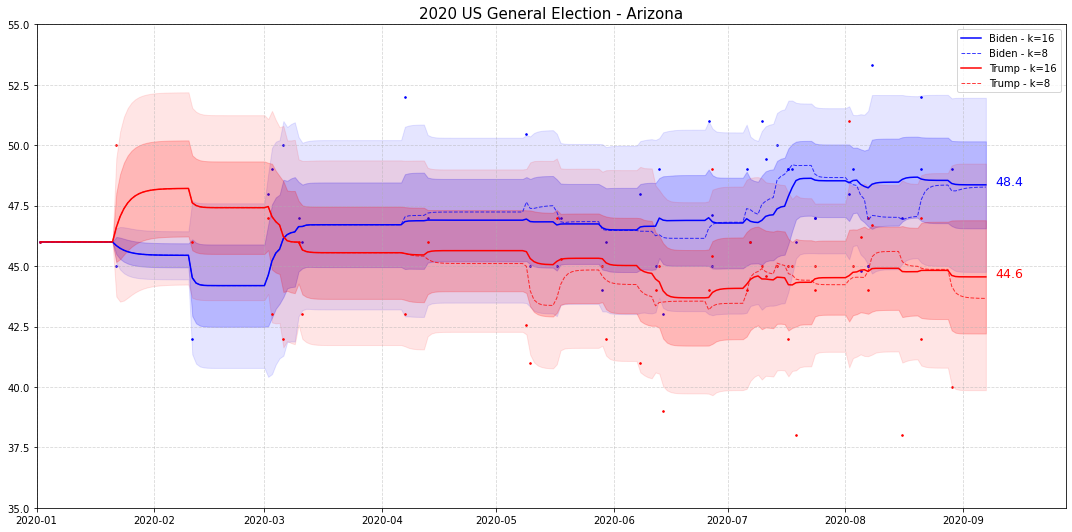

In [27]:
for state in Allstates_diff_k16.loc[Allstates_diff_k16['abs.diff_avg']<4, 'state'].values:
    get_polls_plot_atK(polls2020, state, 16, election=2020)
    get_table_atK(polls2020, state, k=5)

---

---

---

# Trump Job Approval
## 3. how popular is the incumbent president?
---

In [28]:
pr_approval_polls2020 = pd.read_csv(path + '\data\processed\president_approval_polls2020.csv', 
                                    parse_dates=['start_date', 'end_date', 'created_at'], index_col=['start_date'])

In [29]:
pr_approval_polls2020.tail()

,question_id,poll_id,state,politician,pollster_id,pollster,sample_size,population,end_date,created_at,url,approve,disapprove,population_weight,weight,diff
start_date,,,,,,,,,,,,,,,,
2020-08-31,128202,68482,National,Trump,1508,Harris Insights & Analytics,1604,rv,2020-09-02,2020-09-04 16:42:00,https://thehill.com/homenews/campaign/515192-b...,46.0,54.0,0.9,1443.6,-8.0
2020-08-31,128153,68462,National,Trump,399,Rasmussen Reports/Pulse Opinion Research,1500,lv,2020-09-02,2020-09-03 09:23:00,http://www.rasmussenreports.com/public_content...,50.0,49.0,1.0,1500.0,1.0
2020-09-01,128181,68470,National,Trump,568,YouGov,798,rv,2020-09-03,2020-09-03 20:53:00,https://today.yougov.com/_pubapis/v5/us/tracke...,43.0,54.0,0.9,718.2,-11.0
2020-09-01,128194,68476,National,Trump,399,Rasmussen Reports/Pulse Opinion Research,1500,lv,2020-09-03,2020-09-04 09:23:00,http://www.rasmussenreports.com/public_content...,52.0,48.0,1.0,1500.0,4.0
2020-09-02,128240,68498,National,Trump,399,Rasmussen Reports/Pulse Opinion Research,1500,lv,2020-09-06,2020-09-07 09:24:00,http://www.rasmussenreports.com/public_content...,51.0,49.0,1.0,1500.0,2.0


In [30]:
pr_approval_polls2020 = pr_approval_polls2020[pr_approval_polls2020['approve']+pr_approval_polls2020['disapprove'] < 100.]

In [31]:
national_pr_approval2020 = pr_approval_polls2020[pr_approval_polls2020['state'] == 'National']

national_pr_approval2020_k16 = get_state_statsSmooth_atK(pr_approval_polls2020, candidates=['approve', 'disapprove'], state='National', k=16)
national_pr_approval2020_k24 = get_state_statsSmooth_atK(pr_approval_polls2020, candidates=['approve', 'disapprove'], state='National', k=24)

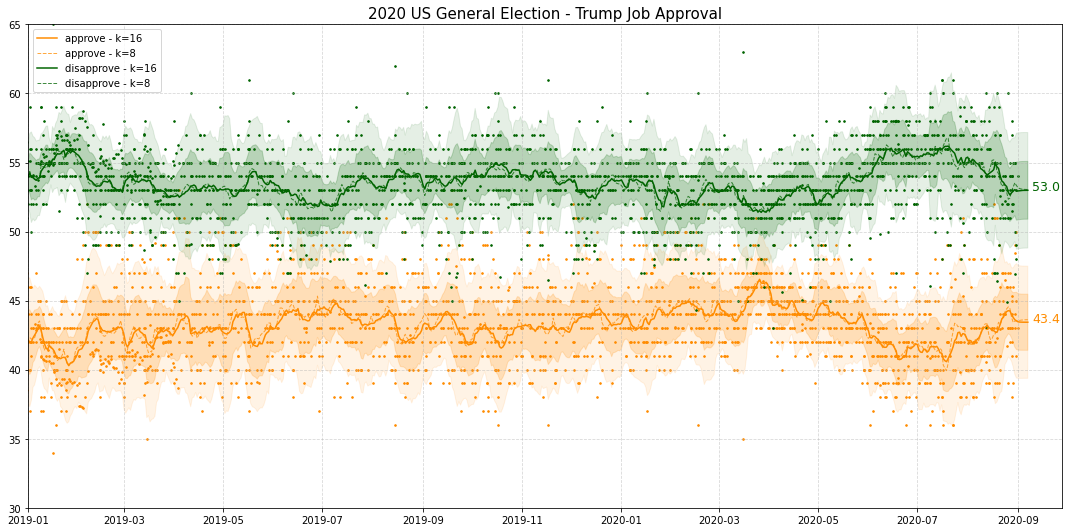

In [32]:
get_polls_plot_atK(pr_approval_polls2020, 'National', k=16, election='pr_approval')

---

---

---

# States: data visualization
---

In [33]:
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import matplotlib.pyplot as plt

import imageio
import glob

In [34]:
election_results = get_election_results()[['diff_2016', 'diff_2012', 'diff_2008']]

In [35]:
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))

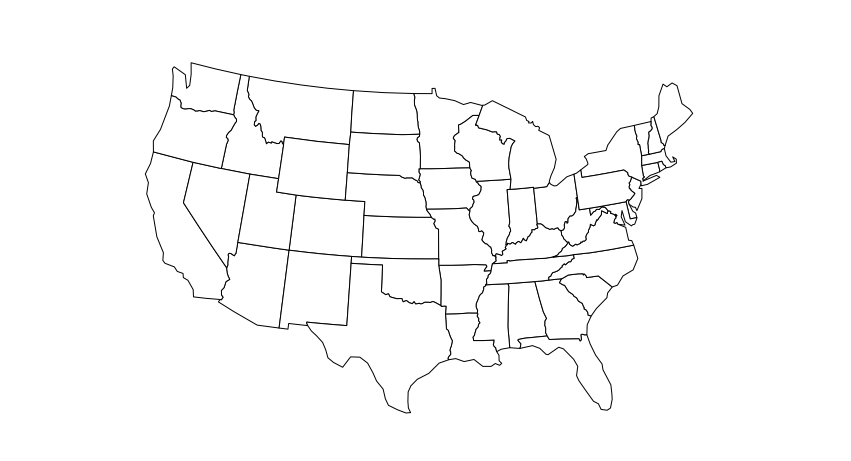

In [36]:
proj = gcrs.AlbersEqualArea()
gplt.polyplot(
    contiguous_usa,
    zorder=-1,
    linewidth=1,
    projection=proj,
    edgecolor='black',
    facecolor='white',
    figsize=(15, 15))


plt.savefig(path+'\\reports\\figures\\US States.png', bbox_inches='tight')
plt.show()

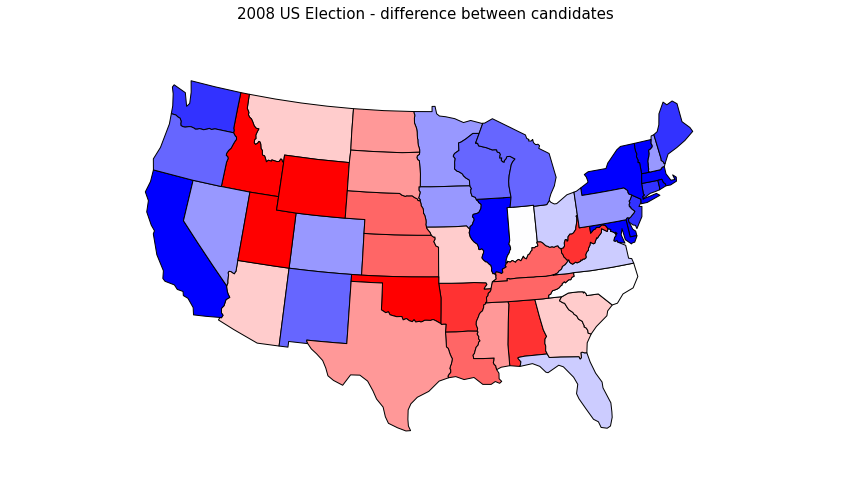

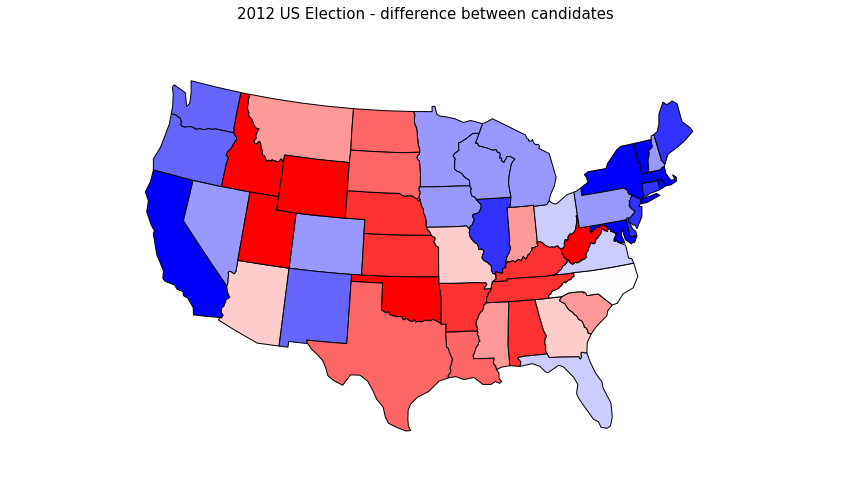

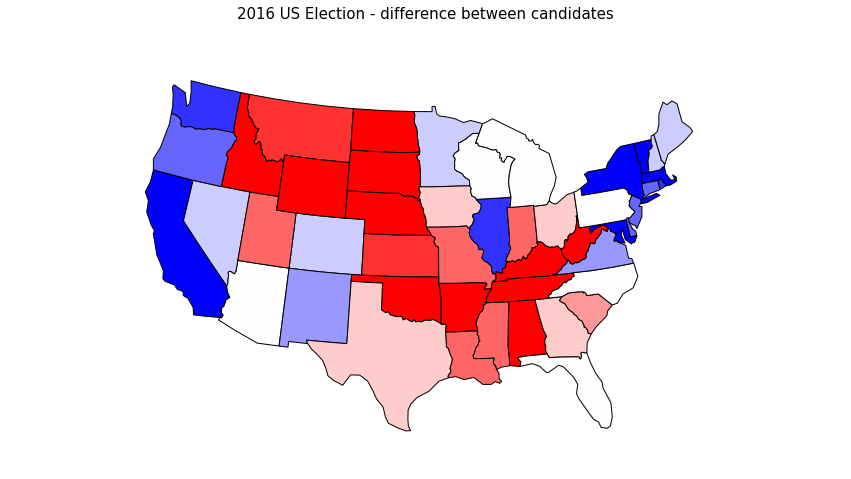

In [37]:
for year in ['2008', '2012', '2016']:
    proj = gcrs.AlbersEqualArea()
    scheme = mc.UserDefined(election_results['diff_'+year], bins=np.arange(-25, 25, 5))

    gplt.choropleth(contiguous_usa.set_index('state').join(election_results), hue='diff_'+year,
                    projection=proj, scheme=scheme,
                    edgecolor='black',
                    cmap='bwr_r', 
                    figsize=(15, 15))

    plt.title(year+' US Election - difference between candidates', fontsize=15)
    plt.savefig(path+'\\reports\\figures\\US States - diff_polls'+year+'.png', bbox_inches='tight')
    plt.show()

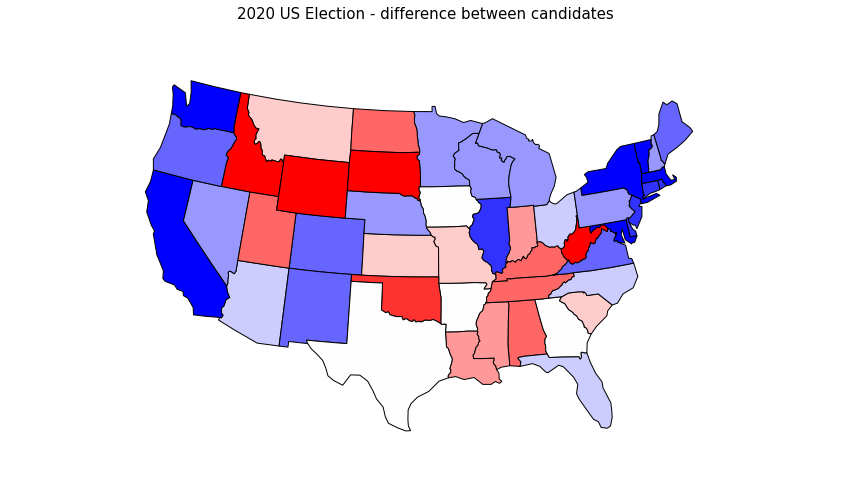

In [38]:
proj = gcrs.AlbersEqualArea()
scheme = mc.UserDefined(Allstates_diff_k16['diff_avg'], bins=np.arange(-25, 25, 5))

gplt.choropleth(contiguous_usa.set_index('state').merge(Allstates_diff_k16, on='state'), hue='diff_avg',
                projection=proj, scheme=scheme,
                edgecolor='black',
                cmap='bwr_r', 
                figsize=(15, 15))

plt.title('2020 US Election - difference between candidates', fontsize=15)
plt.savefig(path+'\\reports\\figures\\US States - diff_polls2020.png', bbox_inches='tight')
plt.show()

In [39]:
filenames = glob.glob(path+'\\reports\\figures\\US States - diff_polls*.png')


with imageio.get_writer(path+'\\reports\\figures\\US_movie.gif', mode='I', fps=0.75) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

---

---

---